In [10]:
!pip install tensorflow matplotlib

In [11]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.data import AUTOTUNE
import matplotlib.pyplot as plt
import os
import numpy as np


In [12]:

# ---------------------------------
# 1. КОНФІГУРАЦІЯ
# ---------------------------------
print("--- Етап 1: Конфігурація ---")

# Шляхи до даних
DATA_DIR = './learning/data'
TRAIN_DIR = os.path.join(DATA_DIR, 'train')
TEST_DIR = os.path.join(DATA_DIR, 'test')

# Параметри моделі
IMAGE_SIZE = (64, 64)
BATCH_SIZE = 128      # 128 або 256 - хороший вибір для великих сетів
COLOR_MODE = 'grayscale'
CHANNELS = 1
NUM_CLASSES = 11    # Дуже важливо! 0-9 плюс клас 10 (сміття)
EPOCHS = 10         # 10 епох для початку. Може знадобитися більше.


--- Етап 1: Конфігурація ---


In [13]:

# ---------------------------------
# 2. ЗАВАНТАЖЕННЯ ДАНИХ (ЕФЕКТИВНО)
# ---------------------------------
print("--- Етап 2: Завантаження даних ---")

# Keras утиліта для завантаження даних з папок
# Вона автоматично знайде класи (0, 1, 2... 10)
# label_mode='categorical' автоматично перетворить ярлики у one-hot
# [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]

print("Завантаження TRAIN датасету...")
train_dataset = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    label_mode='categorical', # <--- Важливо для categorical_crossentropy
    color_mode=COLOR_MODE,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE
)

print("\nЗавантаження TEST (Validation) датасету...")
test_dataset = tf.keras.utils.image_dataset_from_directory(
    TEST_DIR,
    label_mode='categorical',
    color_mode=COLOR_MODE,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False # Перемішування не потрібне для тестування
)

# Отримуємо імена класів (має бути ['0', '1', '10', '2', ...])
class_names = train_dataset.class_names
print(f"\nЗнайдено класи: {class_names}")
if len(class_names) != NUM_CLASSES:
    print(f"ПОМИЛКА: Очікувалось {NUM_CLASSES} класів, але знайдено {len(class_names)}")
    # Тут можна зупинити блокнот


--- Етап 2: Завантаження даних ---
Завантаження TRAIN датасету...
Found 284200 files belonging to 11 classes.

Завантаження TEST (Validation) датасету...
Found 10100 files belonging to 11 classes.

Знайдено класи: ['0', '1', '10', '2', '3', '4', '5', '6', '7', '8', '9']


In [14]:

# ---------------------------------
# 3. ОПТИМІЗАЦІЯ ПАЙПЛАЙНУ ДАНИХ
# ---------------------------------
print("\n--- Етап 3: Оптимізація пайплайну ---")

# .cache() - кешує дані в пам'ять після першого читання
# .prefetch() - готує наступні батчі, поки GPU тренується
# Це КРИТИЧНО для швидкості тренування

train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.cache().prefetch(buffer_size=AUTOTUNE)

print("Пайплайни даних готові.")



--- Етап 3: Оптимізація пайплайну ---
Пайплайни даних готові.


In [15]:
print("\n--- Етап 4: Побудова архітектури (v2.0 з регуляризацією) ---")

# Створюємо "живу" аугментацію як шари моделі
# Вони будуть активні ТІЛЬКИ під час навчання
data_augmentation = keras.Sequential(
  [
    layers.RandomRotation(0.05), # Поворот на ~18 градусів
    layers.RandomZoom(0.1),      # Зум до 10%
    layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
  ],
  name="data_augmentation",
)

# Вхідний шар
inputs = keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], CHANNELS))

# 1. Нормалізація
x = layers.Rescaling(1./255)(inputs)
# 2. "Жива" аугментація
x = data_augmentation(x)

# === Блок 1 ===
x = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x) # <--- ДОДАНО
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Dropout(0.2)(x) # <--- ДОДАНО

# === Блок 2 ===
x = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x) # <--- ДОДАНО
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Dropout(0.3)(x) # <--- ДОДАНО

# === Блок 3 ===
x = layers.Conv2D(128, (3, 3), padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x) # <--- ДОДАНО
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Dropout(0.4)(x) # <--- ДОДАНО

# === Голова класифікатора ===
x = layers.Flatten()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.BatchNormalization()(x) # <--- ДОДАНО
x = layers.Dropout(0.5)(x) # <--- Старий шар, залишаємо

# === Вихідний шар ===
outputs = layers.Dense(NUM_CLASSES, activation='softmax')(x)

# Збираємо модель
model = keras.Model(inputs=inputs, outputs=outputs)


--- Етап 4: Побудова архітектури (v2.0 з регуляризацією) ---


In [16]:
print("\n--- Етап 5: Компіляція моделі (v2.0) ---")

# Ідея №3: Зменшуємо швидкість навчання
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005) # Було 0.001 (default)

model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Виведемо структуру моделі
model.summary()


--- Етап 5: Компіляція моделі (v2.0) ---


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 64, 64, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ (None, 64, 64, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 64, 64, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     1,048,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 11)             │         1,419 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,144,203 (4.36 MB)

 Trainable params: 1,143,499 (4.36 MB)

 Non-trainable params: 704 (2.75 KB)

In [17]:
# 6. НАВЧАННЯ МОДЕЛІ
# ---------------------------------
print("\n--- Етап 6: Початок навчання ---")
print(f"Тренування на {EPOCHS} епох...")

# Створюємо колбек для збереження ТІЛЬКИ найкращої моделі
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='../models/digit_classifier_best.keras', # Збережемо в папку models
    save_best_only=True,
    monitor='val_accuracy',
    mode='max'
)

# Запускаємо процес навчання
history = model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=EPOCHS,
    callbacks=[model_checkpoint] # Додаємо колбек
)

print("\n--- Навчання завершено! ---")



--- Етап 6: Початок навчання ---
Тренування на 10 епох...
Epoch 1/10


E0000 00:00:1762178685.957821     936 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_3_1/dropout_4_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


2221/2221 ━━━━━━━━━━━━━━━━━━━━ 196s 85ms/step - accuracy: 0.8418 - loss: 0.5098 - val_accuracy: 0.9005 - val_loss: 0.4600
Epoch 2/10
2221/2221 ━━━━━━━━━━━━━━━━━━━━ 173s 78ms/step - accuracy: 0.9646 - loss: 0.1146 - val_accuracy: 0.9150 - val_loss: 0.3445
Epoch 3/10
2221/2221 ━━━━━━━━━━━━━━━━━━━━ 169s 76ms/step - accuracy: 0.9745 - loss: 0.0814 - val_accuracy: 0.9355 - val_loss: 0.2756
Epoch 4/10
2221/2221 ━━━━━━━━━━━━━━━━━━━━ 169s 76ms/step - accuracy: 0.9786 - loss: 0.0676 - val_accuracy: 0.8371 - val_loss: 0.4897
Epoch 5/10
2221/2221 ━━━━━━━━━━━━━━━━━━━━ 172s 77ms/step - accuracy: 0.9817 - loss: 0.0578 - val_accuracy: 0.9400 - val_loss: 0.2637
Epoch 6/10
2221/2221 ━━━━━━━━━━━━━━━━━━━━ 169s 76ms/step - accuracy: 0.9834 - loss: 0.0525 - val_accuracy: 0.9324 - val_loss: 0.2986
Epoch 7/10
2221/2221 ━━━━━━━━━━━━━━━━━━━━ 169s 76ms/step - accuracy: 0.9844 - loss: 0.0496 - val_accuracy: 0.9435 - val_loss: 0.2425
Epoch 8/10
2221/2221 ━━━━━━━━━━━━━━━━━━━━ 172s 78ms/step - accuracy: 0.9857 - lo

In [18]:

# ---------------------------------
# 7. ОЦІНКА ТА ЗБЕРЕЖЕННЯ
# ---------------------------------
print("\n--- Етап 7: Оцінка та збереження ---")

# Оцінка на тестовому наборі (дасть ті ж цифри, що й остання епоха)
test_loss, test_acc = model.evaluate(test_dataset)
print(f"\nФінальна точність на тестовому наборі: {test_acc*100:.2f}%")

# Збереження фінальної моделі (не обов'язково найкращої)
model.save('../models/digit_classifier_final.keras')
print(f"Фінальну модель збережено в ../models/digit_classifier_final.keras")
print(f"Найкращу модель збережено в ../models/digit_classifier_best.keras")



--- Етап 7: Оцінка та збереження ---
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.9398 - loss: 0.2700

Фінальна точність на тестовому наборі: 93.98%
Фінальну модель збережено в ../models/digit_classifier_final.keras
Найкращу модель збережено в ../models/digit_classifier_best.keras



--- Етап 8: Візуалізація результатів ---
Графіки навчання збережено в ../models/training_history.png


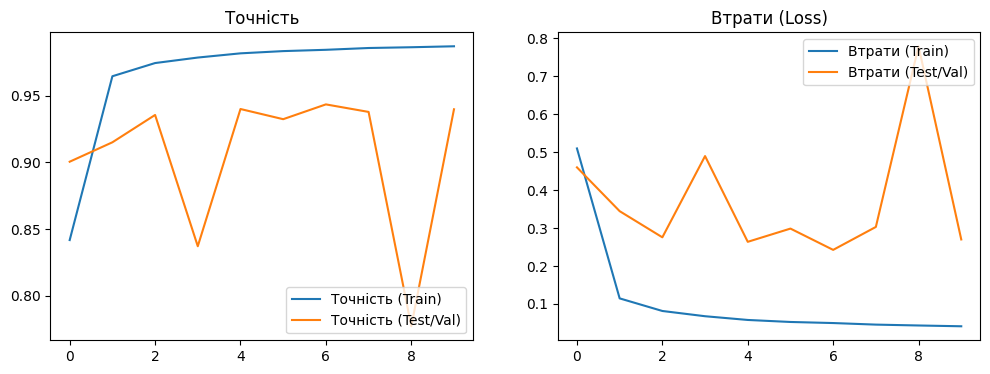

In [19]:

# ---------------------------------
# 8. ВІЗУАЛІЗАЦІЯ РЕЗУЛЬТАТІВ
# ---------------------------------
print("\n--- Етап 8: Візуалізація результатів ---")

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Точність (Train)')
plt.plot(epochs_range, val_acc, label='Точність (Test/Val)')
plt.legend(loc='lower right')
plt.title('Точність')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Втрати (Train)')
plt.plot(epochs_range, val_loss, label='Втрати (Test/Val)')
plt.legend(loc='upper right')
plt.title('Втрати (Loss)')

plt.savefig('../models/training_history.png')
print("Графіки навчання збережено в ../models/training_history.png")
plt.show()